**<center>Project</center>**

**<center>Market microstructure and trading strategy</center>**

**<center>(Recommender system)</center>**


#Overview
**Objective:**

Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

**Attribute Information:**

● user_id : Every user identified with a unique id

● item_id : Every product identified with a unique id

● rating : rating of the corresponding product by the corresponding user

● timestamp : Time of the rating

#Import librairies


In [ ]:
!pip install git+https://github.com/inpefess/recommender-systems-course.git

  Cloning https://github.com/inpefess/recommender-systems-course.git to /tmp/pip-req-build-sw3ewm0u
  Running command git clone -q https://github.com/inpefess/recommender-systems-course.git /tmp/pip-req-build-sw3ewm0u
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Cloning https://github.com/maciejkula/spotlight.git (to revision v0.1.6) to /tmp/pip-install-bhw6rrre/spotlight_8133d794e237410bb84f417958d105bf
  Running command git clone -q https://github.com/maciejkula/spotlight.git /tmp/pip-install-bhw6rrre/spotlight_8133d794e237410bb84f417958d105bf
  Running command git checkout -q ddf77d4829145ed271a3c605ec683176b08b1713
  Using cached implicit-0.4.8-cp37-cp37m-linux_x86_64.whl


In [ ]:
import os
from google.colab import drive

import matplotlib.pyplot as plt

# %matplotlib inline
plt.style.use("ggplot")
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_color_codes()
sns.set(style="whitegrid")
from tqdm import tqdm
from typing import Tuple,Any,Dict,List

from rs_datasets import Amazon
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from lightfm import LightFM

from rs_metrics import coverage,ndcg
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.interactions import Interactions
from sklearn import preprocessing

import torch

torch.cuda.current_device()
torch.cuda.empty_cache()



#Data Collection

In [ ]:
electronics= Amazon("electronics")
electronics.info()

ratings


,user_id,item_id,rating,timestamp
0,0060009810,A1N070NS9CJQ2I,5.0,1026864000
1,0060009810,A3P0KRKOBQK1KN,5.0,1025913600
2,0060009810,A192HO2ICJ75VU,5.0,1025654400


**Shape of the data**

In [ ]:
electronics.ratings.shape

(20994353, 4)

In [ ]:
print("Number of rows = {0} and Number of Columns = {1} in Data frame".format(electronics.ratings.shape[0],electronics.ratings.shape[1]))

Number of rows = 20994353 and Number of Columns = 4 in Data frame


In [ ]:
electronics.ratings.head()

,user_id,item_id,rating,timestamp
0,0060009810,A1N070NS9CJQ2I,5.0,1026864000
1,0060009810,A3P0KRKOBQK1KN,5.0,1025913600
2,0060009810,A192HO2ICJ75VU,5.0,1025654400
3,0060009810,A2T278FKFL3BLT,4.0,1025395200
4,0060009810,A2ZUXVTW8RXBXW,5.0,1025222400


In [ ]:
electronics.ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20994353 entries, 0 to 20994352
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   user_id    object 
 1   item_id    object 
 2   rating     float64
 3   timestamp  int32  
dtypes: float64(1), int32(1), object(2)
memory usage: 560.6+ MB


The dataset is utilizing almost 560MB of disk space due to 20994352 rows and 4 columns.
There will be memory issues unless we make the dataset more dense.

##Take a new subset

**Subset of the Dataset**

Since the data is very big. Consider electronics named dataframe with first 5% of data which contains 20994352 rows and all columns from 0 of dataset.

In [ ]:
# Taking 5% of the dataset
electronics.ratings = electronics.ratings.iloc[:1048000,0:]

#Data cleaning

##Check for missing values

In [ ]:

print('Number of missing values across columns: \n',electronics.ratings.isna().sum())

Number of missing values across columns: 
 user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64


- There are no missing values, so no imputation required

##Check and find the max & min ratings given by user for a particular item

In [ ]:
#Find the minimum and maximum ratings - It is between 1 and 5
print('Minimum rating is: %d' %(electronics.ratings.rating.min()))
print('Maximum rating is: %d' %(electronics.ratings.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [ ]:
print("Total data ")
print("-"*50)
print("\nTotal number of electronics :",electronics.ratings.shape[0])
print("Total number of Users   :", len(np.unique(electronics.ratings.user_id)))
print("Total number of Items  :", len(np.unique(electronics.ratings.item_id)))

Total data 
--------------------------------------------------

Total number of electronics : 1048000
Total number of Users   : 12751
Total number of Items  : 824406


Number of items (825435) is more than number of users(12770)

In [ ]:
#Check and find the max ratings given by user for a particular item
max_ratings = electronics.ratings.groupby(['user_id','item_id'])['rating'].max().sort_values(ascending=False)

In [ ]:
max_ratings.head()

user_id     item_id       
0060009810  A192HO2ICJ75VU    5.0
B0002BEX8W  A47NRR5MQQC9J     5.0
            A3KDNTHXTUCV5T    5.0
            A3KDU4JQCRWPON    5.0
            A3KESNU3TFSUHM    5.0
Name: rating, dtype: float64

In [ ]:
#Check and find the min ratings given by user for a particular item
min_ratings = electronics.ratings.groupby(['user_id','item_id'])['rating'].min().sort_values(ascending=False)

In [ ]:
min_ratings.head()

user_id     item_id       
0060009810  A192HO2ICJ75VU    5.0
B0002BEX8W  A1BNL5EKU6MYHE    5.0
B0002BEV9S  A283I2F60653XT    5.0
            A2DJ76T5745UWH    5.0
            A2E7SZOA4MRYD0    5.0
Name: rating, dtype: float64

After min and max calculation, we see that the ratings are identical for the sample.

To be sure, let us remove duplicates.

##Check Duplicates

In [ ]:
electronics.ratings.drop_duplicates(inplace=True)

No duplicates in this dataset.

#Data Analysis and Preparation

In [ ]:
# Summary statistics of 'rating' variable
electronics.ratings.describe()

,rating,timestamp
count,1.046454e+06,1.046454e+06
mean,4.139762e+00,1.336665e+09
std,1.319234e+00,1.306967e+08
min,1.000000e+00,8.811936e+08
25%,4.000000e+00,1.233533e+09
50%,5.000000e+00,1.377216e+09
75%,5.000000e+00,1.436746e+09
max,5.000000e+00,1.526342e+09


##Check the distribution of the rating

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


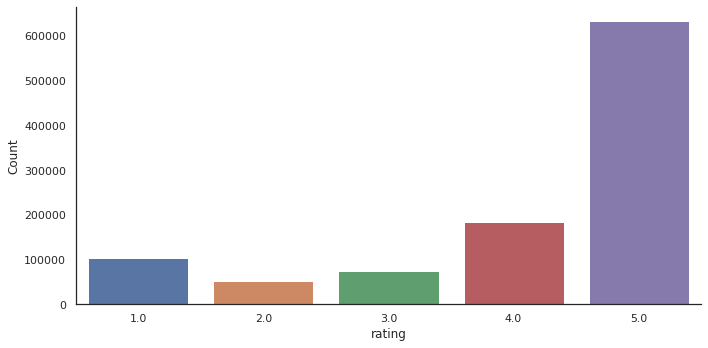

In [ ]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=electronics.ratings, aspect=2.0,kind='count')
    g.set_ylabels("Count")

In [ ]:
# Count users based on ratings
for i in range(1,6):
  print('Number of users who rated {0} rating = {1}'.format(i, electronics.ratings[electronics.ratings['rating'] == i].shape[0]))

Number of users who rated 1 rating = 103089
Number of users who rated 2 rating = 51488
Number of users who rated 3 rating = 74707
Number of users who rated 4 rating = 183966
Number of users who rated 5 rating = 633204


In [ ]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', electronics.ratings['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', electronics.ratings['item_id'].nunique())

Number of unique USERS in Raw data =  12751
Number of unique ITEMS in Raw data =  824406


In [ ]:
# Top 10 users based on rating
most_rated_users = electronics.ratings.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated_users

user_id
B000BQ7GW8    13757
B0006BB9MG     7586
B000A6PPOK     6392
B00004ZCJI     5683
B00004ZCJJ     5683
B00009KLAE     5677
B00007M1TZ     5294
B000BTL0OA     5038
B00020S7XK     4889
B00007E7JU     4701
dtype: int64

In [ ]:
# Top 10 items based on rating
most_rated_items = electronics.ratings.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated_items

user_id
B000BQ7GW8    13757
B0006BB9MG     7586
B000A6PPOK     6392
B00004ZCJI     5683
B00004ZCJJ     5683
B00009KLAE     5677
B00007M1TZ     5294
B000BTL0OA     5038
B00020S7XK     4889
B00007E7JU     4701
dtype: int64

##Analysis of Items rating's given by a particular user

In [ ]:
no_of_rated_items_per_user = electronics.ratings.groupby(by='user_id')['rating'].count().sort_values(ascending=False)
no_of_rated_items_per_user.head()

user_id
B000BQ7GW8    13757
B0006BB9MG     7586
B000A6PPOK     6392
B00004ZCJI     5683
B00004ZCJJ     5683
Name: rating, dtype: int64

We have certain users who have rated only 1 product and few users have rated upto 13757 products.
However the number of rated products per user is fairly skewed seeing the 5 point summary.

Max is 13757 and 75% percentile is at 53.

In [ ]:
no_of_rated_items_per_user.describe().astype(int).T

count    12751
mean        82
std        310
min          1
25%          6
50%         17
75%         53
max      13757
Name: rating, dtype: int64

In [ ]:
print('\n Number of rated items more than 150 per user : {}\n'.format(sum(no_of_rated_items_per_user >= 150)) )


 Number of rated items more than 100 per user : 1336



##Take a new subset of the actual dataset
Filtering the users who has given 150 or more number of ratings


In [ ]:
#Getting the new dataframe which contains users who has given 60 or more ratings
new_df=electronics.ratings.groupby("user_id").filter(lambda x:x['rating'].count() >=150)

###Shape of the data

In [ ]:
new_df.shape

(743455, 4)

###Data type of each attribute

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743455 entries, 743 to 1047999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    743455 non-null  object 
 1   item_id    743455 non-null  object 
 2   rating     743455 non-null  float64
 3   timestamp  743455 non-null  int32  
dtypes: float64(1), int32(1), object(2)
memory usage: 25.5+ MB


###Point summary of numerical attributes

In [ ]:
display(new_df[['rating']].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
rating,743455.0,4.201697,1.279062,1.0,4.0,5.0,5.0,5.0


**Observations**

rating : This is can be considered as categorical attribute with values of (1,2,3,4,5). The mean rating is 4.17 which means most of the users have given very good ratings for the items i.e. many records with ratings above 4. This can be seen from the median (Q2), 75% (Q3) and max values as 5. Even 25% (Q1) value is 4.0.

###Unique Users and Products Count

In [ ]:
print('Total unique users in the dataset', new_df['user_id'].nunique())
print('Total unique items in the dataset', new_df['item_id'].nunique())

Total unique users in the dataset 1336
Total unique items in the dataset 612161


###rating Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


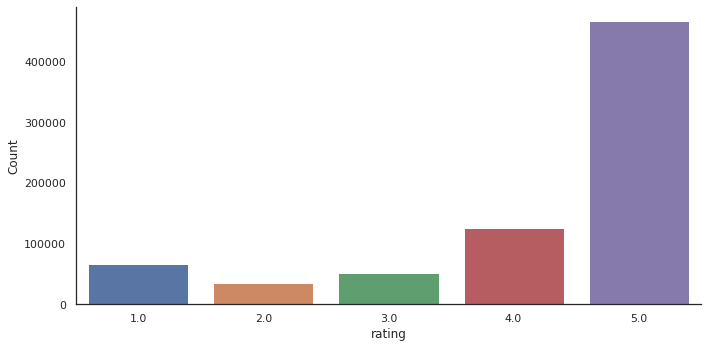

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=new_df, aspect=2.0,kind='count')
    g.set_ylabels("Count")

**Observations**
- Many users have rated 5 as it is shown with the huge spike with a value of more than 400000 records.
- This is followed by rating 4 which also has high number with a value of mroe than 150000 records.
- More than 50000 users have rated 1.
Rating 3 and 2 have been rated below 50000 records.

###Top Rating Count Distribution grouped by Products

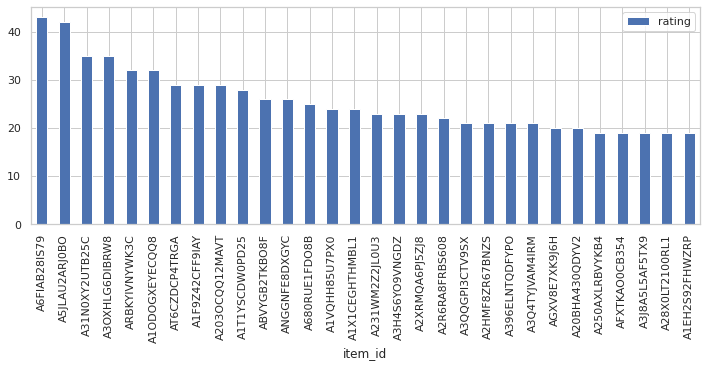

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('item_id')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

###Top Rating Count Distribution grouped by Users

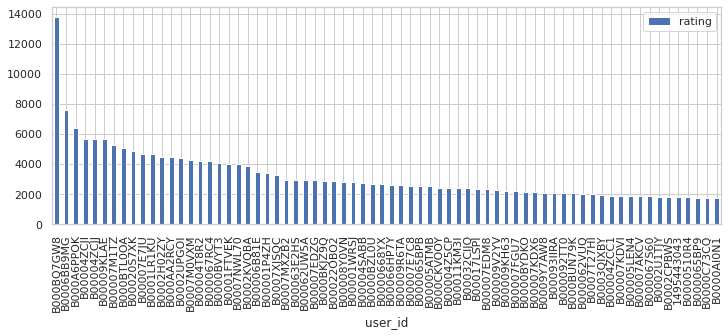

In [ ]:
popular_products = pd.DataFrame(new_df.groupby('user_id')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(70).plot(kind = "bar",figsize=(12, 4))

###Mean Rating Distribution grouped by Products

In [ ]:
item_rating = new_df.groupby('item_id')['rating'].mean()
item_rating.head()

item_id
A0004478EF5NFPHLGCWG    4.0
A000681618A3WRMCK53V    2.0
A0008898NGEXICE0F146    5.0
A0010606488RW7ZH6EP7    3.0
A0012454SJKX2UXGRO5     5.0
Name: rating, dtype: float64

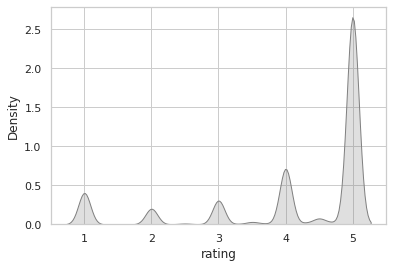

In [ ]:
ax = sns.kdeplot(item_rating, shade=True, color='grey')
plt.show()

**Observations**
This is a mean rating distribution grouped by all the Items.

As it can been seen from the plot, there are many Items which were given a Rating of 4 or 5. Hence the plot shows lot of bins between 4 and 5.

###Mean Rating Distribution grouped by Users

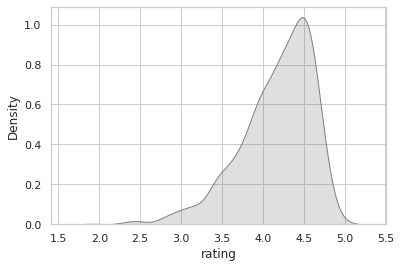

In [ ]:
user_rating = new_df.groupby('user_id')['rating'].mean()
ax = sns.kdeplot(user_rating, shade=True, color='grey')
plt.show()

Observations
This is a mean rating distribution grouped by all the Users. This looks like slightly left skewed normal distribution.

Data is uniformly distribution from rating 3 to 5 with many around 4 to 4.5. Many users have an average rating of around 4.5.

##Convert data to numeric

In [ ]:
def transform_data(data):
  ratings=data

  lab=preprocessing.LabelEncoder()
  user_id=ratings["user_id"]
  item_id=ratings["item_id"]
  trans_user=lab.fit_transform(user_id)
  trans_item=lab.fit_transform(item_id)
  rating=ratings["rating"]
  timestamp=ratings["timestamp"]
  return pd.DataFrame({"user_id":trans_user,"item_id":trans_item,"rating":rating,"timestamp":timestamp})



We will tronsform from categorial to numeric data and keep the new one.

In [ ]:
electronics=transform_data(new_df)
electronics

,user_id,item_id,rating,timestamp
743,0,581059,3.0,1377907200
744,0,203627,1.0,1375401600
745,0,126476,4.0,1372291200
746,0,557823,5.0,1372032000
747,0,72579,5.0,1370649600
...,...,...,...,...
1047995,1335,431670,4.0,1155427200
1047996,1335,383992,4.0,1155168000
1047997,1335,261624,4.0,1155081600
1047998,1335,391266,5.0,1155081600


#Splitting the data

##Validation split

In [ ]:
def electronics_split(
    ratings: pd.DataFrame,
    train_percentage: float,
    warm_users_only: bool = False,
) -> Tuple[csr_matrix, pd.DataFrame, Tuple[int, int]]:
    """
    split ``ratings`` dataset to train and test

    :param ratings: ratings dataset from electronics
    :param train_percentage: percentage of data to put into training dataset
    :param warm_users_only: test on only those users, who were in training set
    :returns: sparse matrix for training and pandas dataset for testing
    """
    time_split = ratings.timestamp.quantile(train_percentage)  # type: ignore
    train = ratings[ratings.timestamp < time_split]
    test = ratings[ratings.timestamp >= time_split]
    if warm_users_only:
        warm_users = list(set(train.user_id).intersection(set(test.user_id)))
        final_test = test[test.user_id.isin(warm_users)]
    else:
        final_test = test
    return (
        train,
        final_test,
        (ratings.user_id.max() + 1, ratings.item_id.max() + 1),
    )

##Sparse matrix

In [ ]:
def pandas_to_scipy(
    pd_dataframe: pd.DataFrame,
    data_name: str,
    rows_name: str,
    cols_name: str,
    shape: Tuple[int, int],
) -> csr_matrix:
    """
    transform pandas dataset with three columns to a sparse matrix

    :param data_name: column name with values for the matrix cells
    :param rows_name: column name with row numbers of the cells
    :param cols_name: column name with column numbers of the cells
    :param shape: a pair (total number of rows, total number of columns)
    :returns: a ``csr_matrix``
    """
    return csr_matrix(
        (
            pd_dataframe[data_name].astype(float),
            (pd_dataframe[rows_name], pd_dataframe[cols_name]),
        ),
        shape=shape,
    )

#Models

##First model: SVD

The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler. It provides another way to factorize a matrix, into singular vectors and singular values.

$A=U.Sigma.V^T$

In [ ]:
def get_svd_recs(
    recommender: TruncatedSVD, sparse_train: csr_matrix, test: pd.DataFrame
) -> Dict[int, List[int]]:
    """
    get recommendations given a truncated SVD decomposition

    :param recommender: a truncated SVD decomposition
    :param sparse_train: a ``scr_matrix`` representation of the train data
    :param test: test data
    :returns: recommendations in ``rs_metrics`` compatible format
    """
    user_embeddings = recommender.transform(sparse_train)
    test_users = test.user_id.unique()
    test_parts = np.array_split(test_users, 3)
    pred = {}
    for test_part in tqdm(test_parts):
        raw_weights = user_embeddings[test_part].dot(recommender.components_)
        no_train_weights = np.where(
            (sparse_train[test_part].toarray() > 0),
            0.0,
            raw_weights,
        )
        pred.update(
            dict(
                zip(
                    test_part,
                    np.argpartition(  # type: ignore
                        -no_train_weights, 10, axis=1
                    )[:, :10],
                )
            )
        )
    return pred

In [ ]:
def SVD():
    """main function of this module"""
    train, test, shape = electronics_split(electronics, 0.95, True)
    sparse_train = pandas_to_scipy(
        train, "rating", "user_id", "item_id", shape
    )
    recommender = TruncatedSVD(n_components=100).fit(sparse_train)
    pred = get_svd_recs(recommender, sparse_train, test)
    return({"ndcg":ndcg(test, pred),"coverage":coverage(test, pred)})

### First metric: ndcg

In [ ]:
def main():
  ndcg_rate=SVD()
  val=ndcg_rate["ndcg"]
  print(f"The rate of SVD by using the ncdg metric is:{val} ")

In [ ]:
if __name__ == "__main__":
    main()

100%|██████████| 3/3 [00:16<00:00,  5.64s/it]


The rate of SVD by using the ncdg metric is:0.0004198221579362521 


### second metric: coverage

In [ ]:
def main():
  coverage_rate=SVD()
  val=coverage_rate["coverage"]
  print(f"The rate of SVD by using the coverage metric is:{val} ")

In [ ]:
if __name__ == "__main__":
    main()

100%|██████████| 3/3 [00:16<00:00,  5.34s/it]


The rate of SVD by using the coverage metric is:0.0019998929823153277 


## Second model: Spotlight

In [ ]:
def get_spotlight_predictions(
    recommender: Any,
    sparse_train: csr_matrix,
    test: pd.DataFrame,
    top_k: int,
    split_test_users_into: int,
) -> Dict[int, List[int]]:
    """
    get recommendations given a spotlight recommender

    :param recommender: a recommender
    :param sparse_train: a ``scr_matrix`` representation of the train data
    :param test: test data
    :param top_k: how many recommendations to return for each user
    :param split_test_users_into: split ``test`` by users into several chunks
        to fit into memory
    :returns: recommendations in ``rs_metrics`` compatible format
    """
    item_ids = np.arange(sparse_train.shape[1], dtype=np.int32)
    test_users_parts = np.array_split(
        test.user_id.unique(), split_test_users_into
    )
    pred = {}
    for test_users_part in tqdm(test_users_parts):
        if isinstance(recommender, LightFM):
            raw_weights_part = recommender.predict(
                np.repeat(test_users_part, item_ids.shape[0]),
                np.tile(item_ids, test_users_part.shape[0]),
                num_threads=os.cpu_count(),
            ).reshape(test_users_part.shape[0], item_ids.shape[0])
        else:
            raw_weights_part = recommender.predict(
                np.repeat(test_users_part, item_ids.shape[0]),
                np.tile(item_ids, test_users_part.shape[0]),
            ).reshape(test_users_part.shape[0], item_ids.shape[0])
        no_train_weights = np.where(
            (sparse_train[test_users_part].toarray() > 0),
            0.0,
            raw_weights_part,
        )
        pred.update(
            dict(
                zip(
                    test_users_part,
                    np.argpartition(  # type: ignore
                        -no_train_weights, top_k, axis=1
                    )[:, :top_k],
                )
            )
        )
    return pred

In [ ]:
def spotlight():
    """main function for this module"""
    train, test, shape = electronics_split(electronics, 0.95, True)
    train_sparse = pandas_to_scipy(
        train, "rating", "user_id", "item_id", shape
    )
    recommender = ImplicitFactorizationModel(
        embedding_dim=128,
        batch_size=2 ** 18,
        use_cuda=True,
        loss="bpr",
        n_iter=15,
        num_negative_samples=1,
    )
    recommender.fit(
        Interactions(
            user_ids=train.user_id.values,
            item_ids=train.item_id.values,
            weights=train.rating.values,
            num_users=shape[0],
            num_items=shape[1],
        ),
        verbose=True,
    )
    pred = get_spotlight_predictions(recommender, train_sparse, test, 10, 100)
    return({"ndcg":ndcg(test, pred),"coverage":coverage(test, pred)})

### First metric:ndcg

In [ ]:
def main():
  ndcg_rate=spotlight()
  val=ndcg_rate["ndcg"]
  print(f"The rate of Spotlight by using the ncdg metric is:{val} ")

In [ ]:
if __name__ == "__main__":
    main()

Epoch 0: loss 0.5005761583646139
Epoch 1: loss 0.4956909418106079
Epoch 2: loss 0.48243166009585065
Epoch 3: loss 0.4559430082639058
Epoch 4: loss 0.41239867607752484
Epoch 5: loss 0.350902001063029
Epoch 6: loss 0.2754007975260417
Epoch 7: loss 0.19586480657259622
Epoch 8: loss 0.12582195550203323
Epoch 9: loss 0.0744649904469649
Epoch 10: loss 0.042434523502985634
Epoch 11: loss 0.02463032677769661
Epoch 12: loss 0.015052981053789457
Epoch 13: loss 0.009971518069505692
Epoch 14: loss 0.007064795897652705


100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


The rate of Spotlight by using the ncdg metric is:0.0003148666184521891 


### second metric: coverage

In [ ]:
def main():
  coverage_rate=spotlight()
  val=coverage_rate["coverage"]
  print(f"The rate of Spotlight by using the coverage metric is:{val} ")

In [ ]:
if __name__ == "__main__":
    main()

Epoch 0: loss 0.500567783912023
Epoch 1: loss 0.4956770141919454
Epoch 2: loss 0.4824229876200358
Epoch 3: loss 0.4559651017189026
Epoch 4: loss 0.4125227133433024
Epoch 5: loss 0.3510671655337016
Epoch 6: loss 0.27554069956143695
Epoch 7: loss 0.19606550534566244
Epoch 8: loss 0.1258778547247251
Epoch 9: loss 0.074527641137441
Epoch 10: loss 0.04250377913316091
Epoch 11: loss 0.024527931585907936
Epoch 12: loss 0.015052754742403826
Epoch 13: loss 0.009918967572351297
Epoch 14: loss 0.007038377535839875


100%|██████████| 100/100 [00:23<00:00,  4.24it/s]


The rate of Spotlight by using the coverage metric is:0.005959547315193835 


#Conclusion

- For the ncdg metric: the spotlight model was better than the SVD.
- For the coverage metric: the spotlight  model was better than the SVD.

Hence, the use of the Spotlight model was efficient and we can improve their performance by using specific methods.